### Example J
Herein, we demonstrate how to implement a futurisitc ULoop closed loop system proposed by Eavor (https://www.eavor.com/technology/).

In [1]:
# Only needed when FGEM is NOT installed by user
import sys
sys.path.insert(1, '../')

from fgem.world import World
from fgem.utils.config import get_config_from_json
from tqdm import tqdm
import numpy as np

In [2]:
def baseload_strategy(project, m_prd=110):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    project.update_state(m_prd)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

def generation_maximization_strategy(project, max_mass_flow=150):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    power_output_MWh_kg = project.powerplant.power_output_MWh_kg
    required_mass_flow_per_well = project.ppc / (power_output_MWh_kg * 3600 * project.num_prd + SMALL_NUM)
    m_prd = np.minimum(max_mass_flow, np.array(project.num_prd*[required_mass_flow_per_well])).astype(float)
    
    project.update_state(m_prd)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()
    
def revenue_maximization_strategy(project, m_prd=100, min_mass_flow=10, max_mass_flow=150):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    if "price_weight" not in project.df_market.columns:
        project.df_market["price_weight"] = project.df_market.price/project.df_market.price.rolling(24).mean().bfill()
        
    m_prd = np.clip(m_prd * project.df_market.loc[project.step_idx+1, "price_weight"], 
                    a_min=min_mass_flow, a_max=max_mass_flow)
    
    project.update_state(m_prd)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh,
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()
    
def seasonal_strategy(project, m_prd=100, max_mass_flow=150):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    month = project.time_curr.month
    if (month >=5) and (month <=8):
        m_prd = max_mass_flow

    project.update_state(m_prd)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh,
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [3]:
# Read configuration file
config = get_config_from_json('configs/exampleJ.json')

project = World(config)

# Iterate over project lifetime
for i in tqdm(range(project.max_simulation_steps)):
    revenue_maximization_strategy(project)

# Compute economics and summary results
project.compute_economics()


https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1564/1564 [00:04<00:00, 328.76it/s]


LCOE: 243 $/MWh
NPV: -85 $MM
PBP: 0 yrs


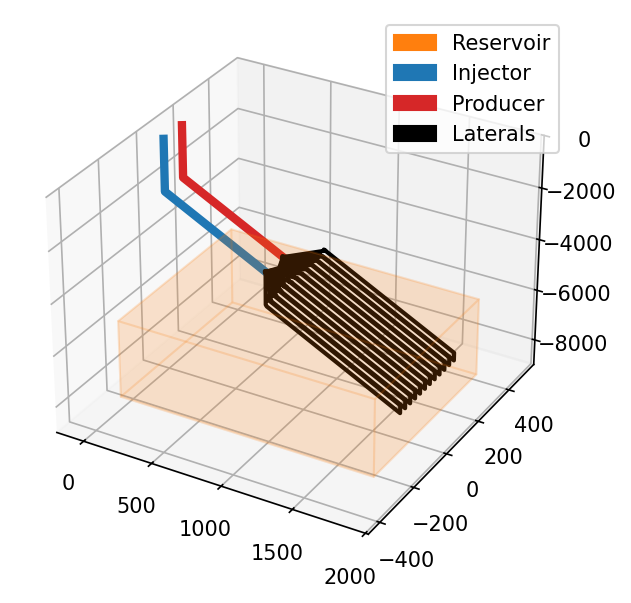

In [5]:
fig = project.reservoir.plot_doublet()

In [7]:
# fig = project.plot_economics()

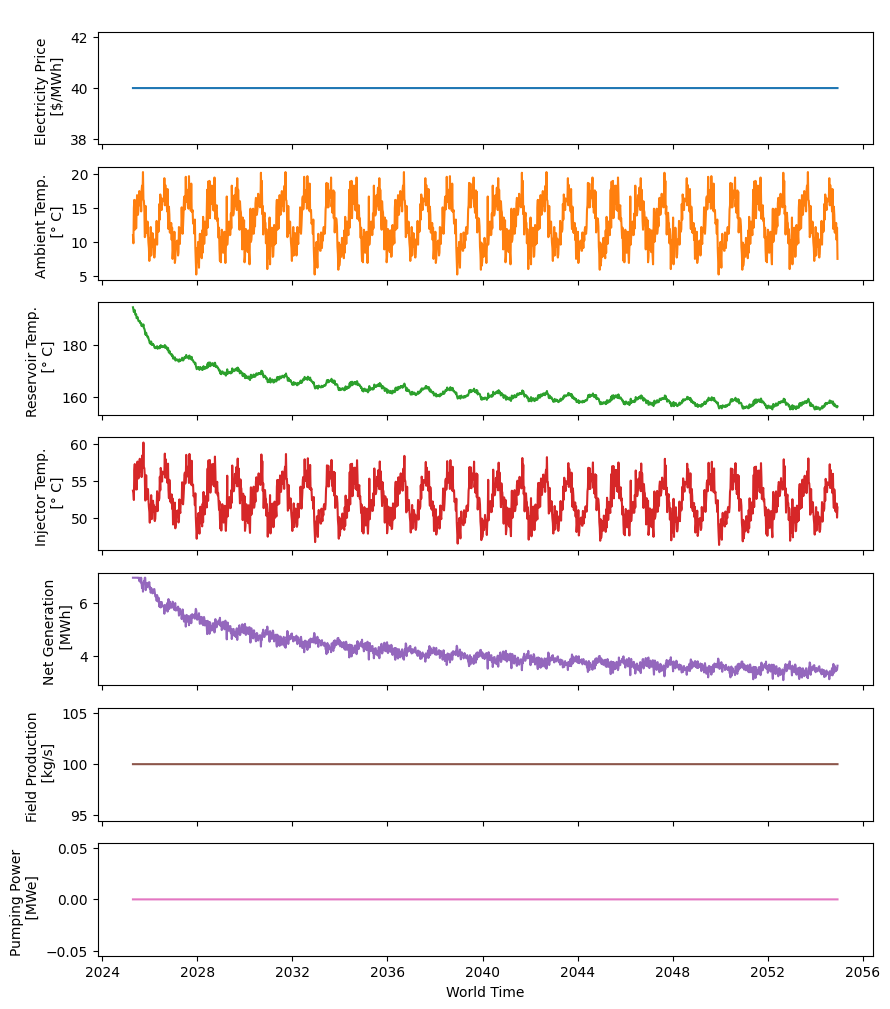

In [8]:
fig = project.plot_operations()